# Applying Differential Privacy to the <i>ExtraSensory Dataset</i>

In [ ]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:
!wget http://extrasensory.ucsd.edu/data/primary_data_files/ExtraSensory.per_uuid_features_labels.zip
!unzip ExtraSensory.per_uuid_features_labels.zip

<a name="read_user_data"></a>
<b>Reading user data</b>.<br/>
Each user has a separate data file that contains several pieces of the data, mainly features and labels.<br/>
To read the different data pieces for a user, you can use the following functions:

In [ ]:
import numpy as np
import gzip
from io import StringIO


def parse_header_of_csv(csv_str):
    # Isolate the headline columns:
    headline = csv_str[:csv_str.index('\n')]
    columns = headline.split(',')

    # The first column should be timestamp:
    assert columns[0] == 'timestamp'
    # The last column should be label_source:
    assert columns[-1] == 'label_source'

    # Search for the column of the first label:
    for (ci, col) in enumerate(columns):
        if col.startswith('label:'):
            first_label_ind = ci
            break
        pass

    # Feature columns come after timestamp and before the labels:
    feature_names = columns[1:first_label_ind];
    # Then come the labels, till the one-before-last column:
    label_names = columns[first_label_ind:-1];
    for (li, label) in enumerate(label_names):
        # In the CSV the label names appear with prefix 'label:', but we don't need it after reading the data:
        assert label.startswith('label:');
        label_names[li] = label.replace('label:', '');
        pass;

    return (feature_names, label_names);


def parse_body_of_csv(csv_str, n_features):
    # Read the entire CSV body into a single numeric matrix:
    full_table = np.loadtxt(StringIO(csv_str), delimiter=',', skiprows=1)

    # Timestamp is the primary key for the records (examples):
    timestamps = full_table[:, 0].astype(int);

    # Read the sensor features:
    X = full_table[:, 1:(n_features + 1)];

    # Read the binary label values, and the 'missing label' indicators:
    trinary_labels_mat = full_table[:, (n_features + 1):-1];  # This should have values of either 0., 1. or NaN
    M = np.isnan(trinary_labels_mat);  # M is the missing label matrix
    Y = np.where(M, 0, trinary_labels_mat) > 0.;  # Y is the label matrix

    return (X, Y, M, timestamps);


'''
Read the data (precomputed sensor-features and labels) for a user.
This function assumes the user's data file is present.
'''


def read_user_data(uuid):
    user_data_file = '%s.features_labels.csv.gz' % uuid;

    # Read the entire csv file of the user:
    with gzip.open(user_data_file, 'rb') as fid:
        csv_str = fid.read()
        pass

    csv_str = csv_str.decode('UTF-8')

    (feature_names, label_names) = parse_header_of_csv(csv_str)
    n_features = len(feature_names);
    (X, Y, M, timestamps) = parse_body_of_csv(csv_str, n_features)

    return (X, Y, M, timestamps, feature_names, label_names)

In [ ]:
def get_sensor_names_from_features(feature_names):
    feat_sensor_names = np.array([None for feat in feature_names]);
    for (fi, feat) in enumerate(feature_names):
        if feat.startswith('raw_acc'):
            feat_sensor_names[fi] = 'Acc';
            pass;
        elif feat.startswith('proc_gyro'):
            feat_sensor_names[fi] = 'Gyro';
            pass;
        elif feat.startswith('raw_magnet'):
            feat_sensor_names[fi] = 'Magnet';
            pass;
        elif feat.startswith('watch_acceleration'):
            feat_sensor_names[fi] = 'WAcc';
            pass;
        elif feat.startswith('watch_heading'):
            feat_sensor_names[fi] = 'Compass';
            pass;
        elif feat.startswith('location'):
            feat_sensor_names[fi] = 'Loc';
            pass;
        elif feat.startswith('location_quick_features'):
            feat_sensor_names[fi] = 'Loc';
            pass;
        elif feat.startswith('audio_naive'):
            feat_sensor_names[fi] = 'Aud';
            pass;
        elif feat.startswith('audio_properties'):
            feat_sensor_names[fi] = 'AP';
            pass;
        elif feat.startswith('discrete'):
            feat_sensor_names[fi] = 'PS';
            pass;
        elif feat.startswith('lf_measurements'):
            feat_sensor_names[fi] = 'LF';
            pass;
        else:
            raise ValueError("!!! Unsupported feature name: %s" % feat);

        pass;

    return feat_sensor_names;

In [ ]:
def project_features_to_selected_sensors(X, feat_sensor_names, sensors_to_use):
    use_feature = np.zeros(len(feat_sensor_names), dtype=bool)
    for sensor in sensors_to_use:
        is_from_sensor = (feat_sensor_names == sensor)
        use_feature = np.logical_or(use_feature, is_from_sensor)
        pass;
    X = X[:, use_feature]
    return X


def estimate_standardization_params(X_train):
    mean_vec = np.nanmean(X_train, axis=0)
    std_vec = np.nanstd(X_train, axis=0)
    return (mean_vec, std_vec)


def standardize_features(X, mean_vec, std_vec):
    # Subtract the mean, to centralize all features around zero:
    X_centralized = X - mean_vec.reshape((1, -1))
    # Divide by the standard deviation, to get unit-variance for all features:
    # * Avoid dividing by zero, in case some feature had estimate of zero variance
    normalizers = np.where(std_vec > 0., std_vec, 1.).reshape((1, -1))
    X_standard = X_centralized / normalizers
    return X_standard


def preprocess_data(X, Y, M, feat_sensor_names, label_names, sensors_to_use, target_labels):
    # Project the feature matrix to the features from the desired sensors:
    X = project_features_to_selected_sensors(X, feat_sensor_names, sensors_to_use)

    # Select target labels
    label_inds = [label_names.index(t) for t in target_labels]
    y = Y[:, label_inds]

    # Select only the examples that are not missing the target labels
    for label_ind in label_inds:
        missing_label = M[:, label_ind]
        existing_label = np.logical_not(missing_label)
        X = X[existing_label, :]
        y = y[existing_label]
        M = M[existing_label]

    # Also, there may be missing sensor-features (represented in the data as NaN).
    # You can handle those by imputing a value of zero (since we standardized,
    # this is equivalent to assuming average value).
    X[np.isnan(X)] = 0.

    return X, y

## Loading Data From Multiple Users

Using cross-validation splits provided by the authors from [here](http://extrasensory.ucsd.edu/data/cv5Folds.zip).

Unzip the file above and store the splits in `cv_5_folds`.

Train data will come from the following splits: 
1. `fold_0_train_android_uuids.txt`
2. `fold_0_train_iphone_uuids.txt`

Test data will come from the following splits:
1. `fold_0_test_android_uuids.txt`
2. `fold_0_test_iphone_uuids.txt`

This information will be useful for performing the membership inference attack later (users in the train and test splits will be members and non-members respectively). 

In [ ]:
train_split_uuids_filepaths = [
    './cv_5_folds/fold_0_train_android_uuids.txt',
    './cv_5_folds/fold_0_train_iphone_uuids.txt',
]

test_split_uuids_filepaths = [
    './cv_5_folds/fold_0_test_android_uuids.txt',
    './cv_5_folds/fold_0_test_iphone_uuids.txt'
]

In [ ]:
def get_uuids_from_filepaths(uuid_filepaths):
    uuids = []
    for filepath in uuid_filepaths:
        with open(filepath, 'r', newline='\n') as f:
            raw_uuids = f.readlines()
            print(f"Adding {len(raw_uuids)} UUIDS from {filepath}")
            clean_uuids = [uuid.strip('\n') for uuid in raw_uuids]
            uuids.extend(clean_uuids)
    return uuids

In [ ]:
!wget http://extrasensory.ucsd.edu/data/cv5Folds.zip
!unzip cv5Folds.zip

--2023-04-21 23:03:29--  http://extrasensory.ucsd.edu/data/cv5Folds.zip
Resolving extrasensory.ucsd.edu (extrasensory.ucsd.edu)... 132.239.17.138
Connecting to extrasensory.ucsd.edu (extrasensory.ucsd.edu)|132.239.17.138|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10803 (11K) [application/zip]
Saving to: ‘cv5Folds.zip’

cv5Folds.zip        100%[===================>]  10.55K  --.-KB/s    in 0s      

2023-04-21 23:03:29 (61.2 MB/s) - ‘cv5Folds.zip’ saved [10803/10803]

Archive:  cv5Folds.zip
   creating: cv_5_folds/
  inflating: cv_5_folds/fold_1_train_android_uuids.txt  
  inflating: cv_5_folds/fold_0_train_iphone_uuids.txt  
  inflating: cv_5_folds/fold_3_test_android_uuids.txt  
  inflating: cv_5_folds/fold_3_train_android_uuids.txt  
  inflating: cv_5_folds/fold_2_train_iphone_uuids.txt  
  inflating: cv_5_folds/fold_4_test_android_uuids.txt  
  inflating: cv_5_folds/fold_1_test_android_uuids.txt  
  inflating: cv_5_folds/fold_2_test_android_uuids.txt  


In [ ]:
train_uuids = get_uuids_from_filepaths(train_split_uuids_filepaths)

Adding 21 UUIDS from ./cv_5_folds/fold_0_train_android_uuids.txt
Adding 27 UUIDS from ./cv_5_folds/fold_0_train_iphone_uuids.txt


In [ ]:
test_uuids = get_uuids_from_filepaths(test_split_uuids_filepaths)

Adding 5 UUIDS from ./cv_5_folds/fold_0_test_android_uuids.txt
Adding 7 UUIDS from ./cv_5_folds/fold_0_test_iphone_uuids.txt


In [ ]:
# Sanity check: intersection of train and test uuids needs to be empty
assert len(list(set(train_uuids) & set(test_uuids))) == 0

In [ ]:
def preprocess_data(X, Y, M, feat_sensor_names, label_names, sensors_to_use, target_labels):
    # Project the feature matrix to the features from the desired sensors:
    X = project_features_to_selected_sensors(X, feat_sensor_names, sensors_to_use);
    
    # Select target labels
    label_inds = [label_names.index(t) for t in target_labels]
    y = Y[:, label_inds]
    
    # Select only the examples that are not missing the target labels
    for label_ind in label_inds:
        missing_label = M[:, label_ind]
        existing_label = np.logical_not(missing_label)
        X = X[existing_label, :]
        y = y[existing_label]
        M = M[existing_label]

    # Also, there may be missing sensor-features (represented in the data as NaN).
    # You can handle those by imputing a value of zero (since we standardized, this is equivalent to assuming average value).
    # You can also further select examples - only those that have values for all the features.
    # For this tutorial, let's use the simple heuristic of zero-imputation:
    X[np.isnan(X)] = 0.
    
    return X, y

In [ ]:
def get_train_and_test_data(train_uuids, test_uuids, sensors_to_use, target_labels):
    X_train, y_train = [], []
    for uuid in train_uuids: 
        X, Y, M, timestamps, feature_names, label_names = read_user_data(uuid)
        feat_sensor_names = get_sensor_names_from_features(feature_names);
        X, y = preprocess_data(X, Y, M, feat_sensor_names, label_names, sensors_to_use, target_labels)
        X_train.extend(X)
        y_train.extend(y)
        print(f"Added data from UUID {uuid} to train data.")
        
    # Standardize the features (subtract mean and divide by standard deviation),
    # so that all their values will be roughly in the same range:
    mean_vec, std_vec = estimate_standardization_params(X_train);
    X_train = standardize_features(X_train, mean_vec, std_vec)
        
    X_test, y_test = [], []
    for uuid in test_uuids: 
        X, Y, M, timestamps, feature_names, label_names = read_user_data(uuid)
        feat_sensor_names = get_sensor_names_from_features(feature_names);
        X, y = preprocess_data(X, Y, M, feat_sensor_names, label_names, sensors_to_use, target_labels)
        X_test.extend(X)
        y_test.extend(y)
        print(f"Added data from UUID {uuid} to test data.")
        
    # Apply same standardization for test data
    X_test = standardize_features(X_test, mean_vec, std_vec)
    
    X_train = np.array(X_train, np.float32)
    y_train = np.array(y_train, dtype=int)
    X_test = np.array(X_test, np.float32)
    y_test = np.array(y_test, dtype=int)
        
    return X_train, y_train, X_test, y_test

In [ ]:
sensors_to_use = ['Acc', 'WAcc', 'Loc', 'Aud']
target_labels = ['FIX_walking', 'LYING_DOWN', 'SITTING']
X_train, y_train, X_test, y_test = get_train_and_test_data(train_uuids, test_uuids, sensors_to_use, target_labels)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(250906, 115)
(250906, 3)
(52817, 115)
(52817, 3)


## Non-Private and Private HAR Models Using PyTorch

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, auc, roc_curve, RocCurveDisplay
!pip install opacus
from opacus import PrivacyEngine
from tqdm import tqdm

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!mkdir models

## Dataloaders

In [ ]:
# Transform data to PyTorch tensors
X_train, y_train = torch.Tensor(X_train), torch.Tensor(y_train)
X_test, y_test = torch.Tensor(X_test), torch.Tensor(y_test)

# Dataset hyperparameters
batch_size = 256
shuffle_train = True
num_classes = y_test.shape[1]

# Create PyTorch dataloaders
train_dataloader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=shuffle_train)
test_dataloader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

## Generic Training and Testing Code

In [ ]:
def train(args, model, device, train_loader, 
          optimizer, privacy_engine, epoch,
          channel_format=None):
    model.train(True)
    criterion = nn.BCELoss()  # can't use cross entropy for multi-label
    losses = []
    for _batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)

        if channel_format == 'channels_last':
            data = torch.unsqueeze(data, 2)
            data = data.permute(0, 2, 1)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)

        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    if not args["disable_dp"]:
        epsilon = privacy_engine.accountant.get_epsilon(delta=args['delta'])
        print(
            f"Train Epoch: {epoch} \t"
            f"Loss: {np.mean(losses):.6f} "
            f"(ε = {epsilon:.2f}, δ = {args['delta']})"
        )
    else:
        print(f"Train Epoch: {epoch} \t Loss: {np.mean(losses):.6f}")

    return np.mean(losses)

In [ ]:
def test(model, device, test_loader, channel_format=None):
    model.eval()
    criterion = nn.BCELoss()
    losses = []
    with torch.no_grad():
        for data, target in tqdm(test_loader):
            data, target = data.to(device), target.to(device)

            if channel_format == 'channels_last':
                data = torch.unsqueeze(data, 2)
                data = data.permute(0, 2, 1)

            output = model(data)
            loss = criterion(output, target).item()
            losses.append(loss)

    test_loss = np.mean(losses)
    print(f"Test Loss: {test_loss:.6f}")
    return test_loss

In [ ]:
def compute_accuracy(model, device, dataloader, channel_format=None):
    model.eval()
    
    num_correct = 0
    num_samples = 0
    with torch.no_grad():
        for data, target in dataloader:
            data = data.to(device)
            target = target.to(device)

            if channel_format == 'channels_last':
                data = torch.unsqueeze(data, 2)
                data = data.permute(0, 2, 1)
            
            scores = model(data)
            
            preds = scores > 0.5
            num_correct += accuracy_score(target.to('cpu'), 
                                          preds.to('cpu'), 
                                          normalize=False)
            num_samples += len(data)
                
    model.train(True)
        
    total_acc = num_correct/num_samples
    print("Computed accuracy:", total_acc)
    return total_acc

In [ ]:
def plot_train_and_test_loss(model_id, train_losses, test_losses):
    fig, ax = plt.subplots()
    
    ax.plot(train_losses, label='Train Loss')
    ax.plot(test_losses, label='Test Loss')
    
    ax.set_title(f"Model: {model_id}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    
    ax.legend()
    plt.show()

In [ ]:
def plot_train_and_test_acc(model_id, train_accs, test_accs):
    fig, ax = plt.subplots()
    
    ax.plot(train_accs, label='Train Acc')
    ax.plot(test_accs, label='Test Acc')
        
    ax.set_title(f"Model: {model_id}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Acc")
    
    ax.legend()
    plt.show()

## Generic Membership Inference Code

In [ ]:
def get_loss_values(model, device, dataloader, channels_format=None):
    model.eval()
    criterion = nn.BCELoss()

    loss_values = []
    with torch.no_grad():
        for data, target in tqdm(dataloader):
            data, target = data.to(device), target.to(device)

            if channels_format == 'channels_last':
                data = torch.unsqueeze(data, 2)
                data = data.permute(0, 2, 1)

            output = model(data)

            for one_output, one_target in zip(target, output):
                loss = criterion(one_output, one_target).item()
                loss_values.append(loss)
    
    model.train(True)
    return loss_values

In [ ]:
def plot_train_and_test_losses(train_loss_values, test_loss_values):
    train_loss_values = np.array(train_loss_values)
    test_loss_values = np.array(test_loss_values)

    train_loss_values = train_loss_values[train_loss_values != 0]
    test_loss_values = test_loss_values[test_loss_values != 0]

    loss_value_types = ['Train'] * len(train_loss_values)
    loss_value_types.extend(['Test'] * len(test_loss_values))
    data_dict = {
        'loss_values': np.concatenate([train_loss_values, test_loss_values]),
        'Data': loss_value_types
    }

    fig, ax = plt.subplots()
    sns.histplot(data=data_dict, 
                x='loss_values',
                hue='Data',
                stat="probability",
                # binwidth=0.01,
                log_scale=True,
                kde=True,
                hue_order=['Train', 'Test'],
                palette=['g', 'b'],
                common_norm=False)
    ax.set_xlabel('Loss Value')
    ax.set_ylabel('Fraction')
    plt.tight_layout()

    plt.show()

In [ ]:
def get_mia_model_roc_curve(train_loss_values, test_loss_values):
    loss_values = np.concatenate(
        [train_loss_values, test_loss_values]
    ).reshape(-1, 1)
    true_membership_labels = [1] * len(train_loss_values)
    true_membership_labels.extend([0] * len(test_loss_values))

    mia_attack_model = LogisticRegression(
        class_weight='balanced'
    );
    mia_attack_model.fit(loss_values, true_membership_labels);

    RocCurveDisplay.from_estimator(mia_attack_model, 
                                   loss_values,
                                   true_membership_labels)
    plt.show()

## Simple NN

In [ ]:
# Define a HAR model
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.sigm = nn.Sigmoid()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.sigm(x)
        return x

### Train Non-Private Simple NN

In [ ]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(device)

cuda


In [ ]:
# Define hyperparameters
non_private_simple_nn_args = {
    'epochs': 10,  # number of epochs for training model
    'lr': 0.0001,  # learning rate for training model
    'disable_dp': True,  # non-private training
}

input_size = X_train.shape[1]  # 115
num_classes = y_train.shape[1]  # 51
non_private_simple_nn_model = SimpleNN(input_size, num_classes).to(device)

model_id = 'non_private_simple_nn'
non_private_simple_nn_optimizer = optim.Adam(
    non_private_simple_nn_model.parameters(), 
    lr=non_private_simple_nn_args['lr'], 
)
privacy_engine = None

In [ ]:
# Train and test model
train_losses, test_losses = [], []
train_accs, test_accs = [], []
for epoch in range(1, non_private_simple_nn_args['epochs'] + 1):
    train_loss = train(
        non_private_simple_nn_args, 
        non_private_simple_nn_model, 
        device, 
        train_dataloader, 
        non_private_simple_nn_optimizer, 
        privacy_engine, 
        epoch
    )
    train_losses.append(train_loss)
    
    train_acc = compute_accuracy(
        non_private_simple_nn_model, 
        device,
        train_dataloader
    )
    train_accs.append(train_acc)
    
    test_loss = test(non_private_simple_nn_model, device, test_dataloader)
    test_losses.append(test_loss)
    
    test_acc = compute_accuracy(
        non_private_simple_nn_model, 
        device,
        test_dataloader
    )
    test_accs.append(test_acc)

100%|██████████| 981/981 [00:05<00:00, 164.33it/s]


Train Epoch: 1 	 Loss: 0.381142
Computed accuracy: 0.6830805162092577


100%|██████████| 207/207 [00:00<00:00, 483.92it/s]


Test Loss: 0.385225
Computed accuracy: 0.6331294848249617


100%|██████████| 981/981 [00:03<00:00, 314.50it/s]


Train Epoch: 2 	 Loss: 0.321780
Computed accuracy: 0.703865192542227


100%|██████████| 207/207 [00:00<00:00, 483.82it/s]


Test Loss: 0.385558
Computed accuracy: 0.639472139652006


100%|██████████| 981/981 [00:03<00:00, 312.62it/s]


Train Epoch: 3 	 Loss: 0.306419
Computed accuracy: 0.7233465919507704


100%|██████████| 207/207 [00:00<00:00, 482.27it/s]


Test Loss: 0.379655
Computed accuracy: 0.6474809247022739


100%|██████████| 981/981 [00:03<00:00, 311.45it/s]


Train Epoch: 4 	 Loss: 0.295928
Computed accuracy: 0.7317760436179286


100%|██████████| 207/207 [00:00<00:00, 482.11it/s]


Test Loss: 0.376478
Computed accuracy: 0.6484843894958062


100%|██████████| 981/981 [00:03<00:00, 311.22it/s]


Train Epoch: 5 	 Loss: 0.288152
Computed accuracy: 0.7387029405434704


100%|██████████| 207/207 [00:00<00:00, 385.20it/s]


Test Loss: 0.379813
Computed accuracy: 0.6450763958573944


100%|██████████| 981/981 [00:03<00:00, 325.00it/s]


Train Epoch: 6 	 Loss: 0.281599
Computed accuracy: 0.7475349334013535


100%|██████████| 207/207 [00:00<00:00, 484.41it/s]


Test Loss: 0.381884
Computed accuracy: 0.6496393206732681


100%|██████████| 981/981 [00:03<00:00, 326.19it/s]


Train Epoch: 7 	 Loss: 0.276495
Computed accuracy: 0.7535730512622257


100%|██████████| 207/207 [00:00<00:00, 482.50it/s]


Test Loss: 0.383786
Computed accuracy: 0.6480678569400004


100%|██████████| 981/981 [00:03<00:00, 310.94it/s]


Train Epoch: 8 	 Loss: 0.272193
Computed accuracy: 0.7570763552884348


100%|██████████| 207/207 [00:00<00:00, 484.07it/s]


Test Loss: 0.386603
Computed accuracy: 0.6492985213094269


100%|██████████| 981/981 [00:03<00:00, 314.31it/s]


Train Epoch: 9 	 Loss: 0.267935
Computed accuracy: 0.7617633695487553


100%|██████████| 207/207 [00:00<00:00, 486.93it/s]


Test Loss: 0.386682
Computed accuracy: 0.6438078648919855


100%|██████████| 981/981 [00:03<00:00, 315.12it/s]


Train Epoch: 10 	 Loss: 0.264342
Computed accuracy: 0.7650554390887424


100%|██████████| 207/207 [00:00<00:00, 464.25it/s]


Test Loss: 0.392326
Computed accuracy: 0.6432777325482326


In [ ]:
torch.save({
    'epoch': non_private_simple_nn_args['epochs'],
    'model_state_dict': non_private_simple_nn_model.state_dict(),
    'optimizer_state_dict': non_private_simple_nn_optimizer.state_dict(),
}, f"models/{model_id}")

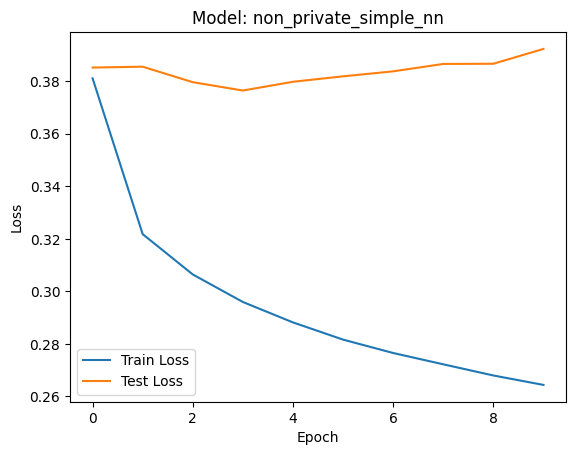

In [ ]:
plot_train_and_test_loss(model_id, train_losses, test_losses)

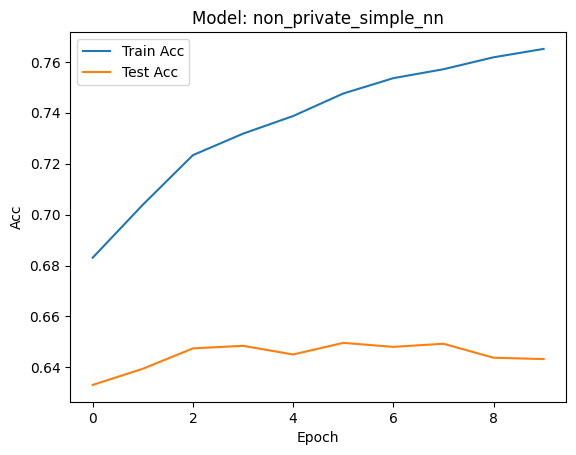

In [ ]:
plot_train_and_test_acc(model_id, train_accs, test_accs)

### Membership Inference Attack on Non-Private Simple NN

In [ ]:
train_loss_values = get_loss_values(non_private_simple_nn_model, 
                                    device, train_dataloader)
test_loss_values = get_loss_values(non_private_simple_nn_model, 
                                   device, test_dataloader)

100%|██████████| 207/207 [00:03<00:00, 63.07it/s]


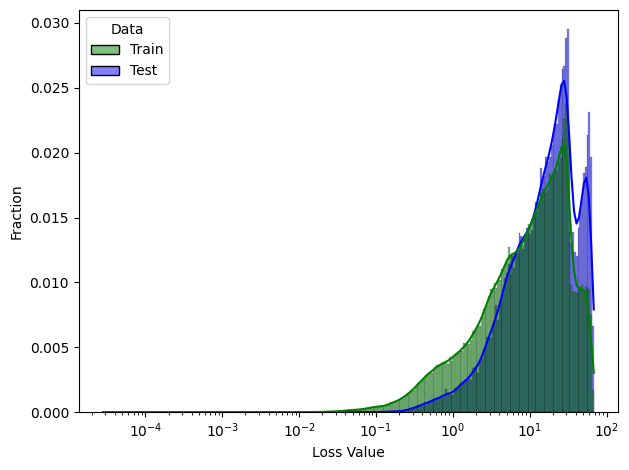

In [ ]:
plot_train_and_test_losses(train_loss_values, test_loss_values)

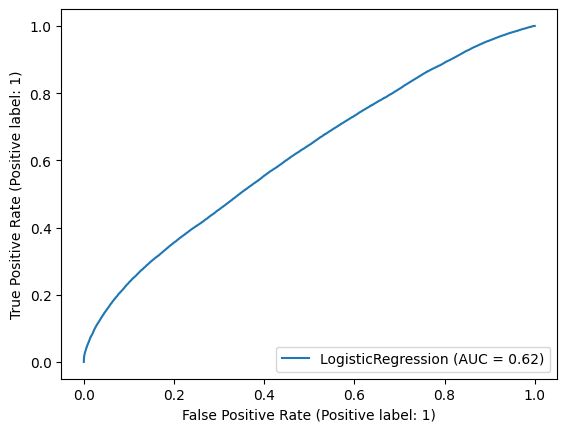

In [ ]:
get_mia_model_roc_curve(train_loss_values, test_loss_values)

### Train Private Simple NN

In [ ]:
# Define hyperparameters
private_simple_nn_args = {
    'epochs': 10,  # number of epochs for training model
    'lr': 0.0001,  # learning rate for training model
    'disable_dp': False,  # non-private training,
     # flag to enable secure RNG to have trustworthy privacy guarantees (comes at a performance cost)
    'secure_rng': False,  
    'epsilon': 0.125,
    'delta': 1e-5,  # target delta for (eps, delta)-DP
    'max_per_sample_grad_norm': 1.0  # per-sample clipping norm for DP-SGD
}

input_size = X_train.shape[1]
num_classes = y_train.shape[1]
private_simple_nn_model = SimpleNN(input_size, num_classes).to(device)

model_id = 'private_simple_nn'
private_simple_nn_optimizer = optim.Adam(
    private_simple_nn_model.parameters(), 
    lr=private_simple_nn_args['lr'], 
)
privacy_engine = PrivacyEngine(secure_mode=private_simple_nn_args['secure_rng'])

private_simple_nn_model, private_simple_nn_optimizer, train_dataloader = privacy_engine.make_private_with_epsilon(
    module=private_simple_nn_model,
    optimizer=private_simple_nn_optimizer,
    data_loader=train_dataloader,
    target_epsilon=private_simple_nn_args['epsilon'],
    target_delta=private_simple_nn_args['delta'],
    epochs=private_simple_nn_args['epochs'],
    max_grad_norm=private_simple_nn_args['max_per_sample_grad_norm'],
)

/usr/local/lib/python3.9/dist-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/opacus/accountants/analysis/prv/prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)


In [ ]:
# Train and test model
train_losses, test_losses = [], []
train_accs, test_accs = [], []
for epoch in range(1, private_simple_nn_args['epochs'] + 1):
    train_loss = train(
        private_simple_nn_args, 
        private_simple_nn_model, 
        device, 
        train_dataloader, 
        private_simple_nn_optimizer, 
        privacy_engine, 
        epoch
    )
    train_losses.append(train_loss)

    train_acc = compute_accuracy(
        private_simple_nn_model, 
        device,
        train_dataloader
    )
    train_accs.append(train_acc)
    
    test_loss = test(private_simple_nn_model, device, test_dataloader)
    test_losses.append(test_loss)

    test_acc = compute_accuracy(
        private_simple_nn_model, 
        device,
        test_dataloader
    )
    test_accs.append(test_acc)

  0%|          | 0/980 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
100%|██████████| 980/980 [00:08<00:00, 113.08it/s]


Train Epoch: 1 	Loss: 0.548032 (ε = 0.04, δ = 1e-05)
Computed accuracy: 0.3257381642280706


100%|██████████| 207/207 [00:00<00:00, 457.04it/s]


Test Loss: 0.510165
Computed accuracy: 0.2762557509892648


  0%|          | 0/980 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
100%|██████████| 980/980 [00:08<00:00, 110.32it/s]
/usr/local/lib/python3.9/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/opacus/accountants/analysis/prv/prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)


Train Epoch: 2 	Loss: 0.472574 (ε = 0.06, δ = 1e-05)
Computed accuracy: 0.5520259073961952


100%|██████████| 207/207 [00:00<00:00, 451.57it/s]


Test Loss: 0.485796
Computed accuracy: 0.5386712611469792


  0%|          | 0/980 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
100%|██████████| 980/980 [00:08<00:00, 110.15it/s]
/usr/local/lib/python3.9/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/opacus/accountants/analysis/prv/prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)


Train Epoch: 3 	Loss: 0.466130 (ε = 0.07, δ = 1e-05)
Computed accuracy: 0.5816832078121011


100%|██████████| 207/207 [00:00<00:00, 452.76it/s]


Test Loss: 0.487602
Computed accuracy: 0.5653672113145389


  0%|          | 0/980 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
100%|██████████| 980/980 [00:08<00:00, 109.81it/s]
/usr/local/lib/python3.9/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/opacus/accountants/analysis/prv/prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)


Train Epoch: 4 	Loss: 0.467458 (ε = 0.08, δ = 1e-05)
Computed accuracy: 0.6067097318574948


100%|██████████| 207/207 [00:00<00:00, 455.88it/s]


Test Loss: 0.485802
Computed accuracy: 0.5844330423916542


  0%|          | 0/980 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
100%|██████████| 980/980 [00:08<00:00, 111.99it/s]
/usr/local/lib/python3.9/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/opacus/accountants/analysis/prv/prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)


Train Epoch: 5 	Loss: 0.461673 (ε = 0.08, δ = 1e-05)
Computed accuracy: 0.6281911516298684


100%|██████████| 207/207 [00:00<00:00, 374.43it/s]


Test Loss: 0.488786
Computed accuracy: 0.5935210254274192


  0%|          | 0/980 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
100%|██████████| 980/980 [00:08<00:00, 110.72it/s]
/usr/local/lib/python3.9/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/opacus/accountants/analysis/prv/prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)


Train Epoch: 6 	Loss: 0.456507 (ε = 0.09, δ = 1e-05)
Computed accuracy: 0.6367117090112666


100%|██████████| 207/207 [00:00<00:00, 460.97it/s]


Test Loss: 0.495009
Computed accuracy: 0.5983679497131605


  0%|          | 0/980 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
100%|██████████| 980/980 [00:08<00:00, 111.09it/s]
/usr/local/lib/python3.9/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/opacus/accountants/analysis/prv/prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)


Train Epoch: 7 	Loss: 0.459571 (ε = 0.10, δ = 1e-05)
Computed accuracy: 0.6428921344108076


100%|██████████| 207/207 [00:00<00:00, 447.39it/s]


Test Loss: 0.500856
Computed accuracy: 0.6035556733627431


  0%|          | 0/980 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
100%|██████████| 980/980 [00:09<00:00, 108.59it/s]
/usr/local/lib/python3.9/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/opacus/accountants/analysis/prv/prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)


Train Epoch: 8 	Loss: 0.460766 (ε = 0.11, δ = 1e-05)
Computed accuracy: 0.6475852080564685


100%|██████████| 207/207 [00:00<00:00, 443.85it/s]


Test Loss: 0.505260
Computed accuracy: 0.6104095272355492


  0%|          | 0/980 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
100%|██████████| 980/980 [00:08<00:00, 111.57it/s]
/usr/local/lib/python3.9/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/opacus/accountants/analysis/prv/prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)


Train Epoch: 9 	Loss: 0.461421 (ε = 0.11, δ = 1e-05)
Computed accuracy: 0.652975831960527


100%|██████████| 207/207 [00:00<00:00, 461.03it/s]


Test Loss: 0.510659
Computed accuracy: 0.6176041804721965


  0%|          | 0/980 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
100%|██████████| 980/980 [00:08<00:00, 111.12it/s]
/usr/local/lib/python3.9/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/opacus/accountants/analysis/prv/prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)


Train Epoch: 10 	Loss: 0.461098 (ε = 0.12, δ = 1e-05)
Computed accuracy: 0.6568145023008765


100%|██████████| 207/207 [00:00<00:00, 460.23it/s]


Test Loss: 0.511876
Computed accuracy: 0.6237953689153114


In [ ]:
torch.save({
    'epoch': private_simple_nn_args['epochs'],
    'model_state_dict': private_simple_nn_model.state_dict(),
    'optimizer_state_dict': private_simple_nn_optimizer.state_dict(),
}, f"models/{model_id}")

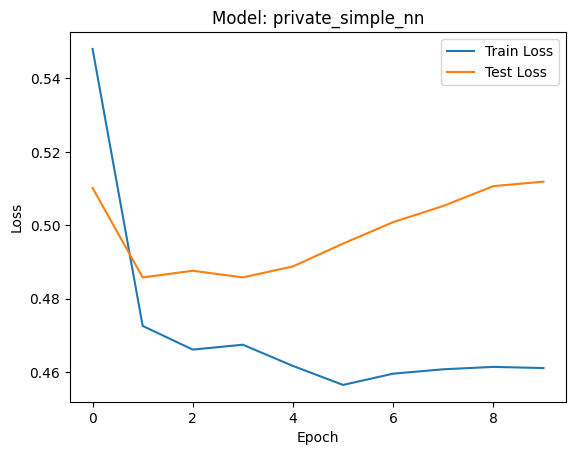

In [ ]:
plot_train_and_test_loss(model_id, train_losses, test_losses)

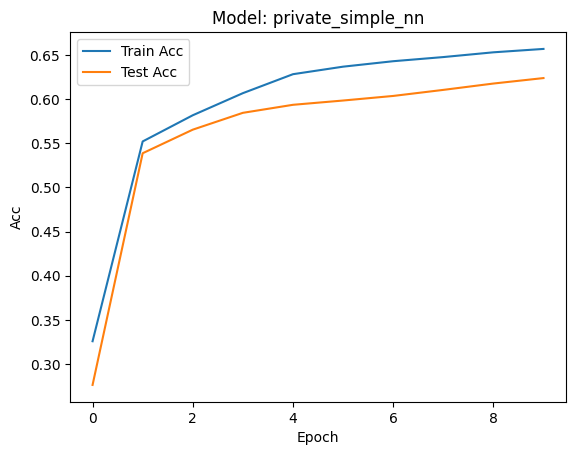

In [ ]:
plot_train_and_test_acc(model_id, train_accs, test_accs)

### Membership Inference Attack on Private Simple NN

In [ ]:
train_loss_values = get_loss_values(private_simple_nn_model, 
                                    device, train_dataloader)
test_loss_values = get_loss_values(private_simple_nn_model, 
                                   device, test_dataloader)

100%|██████████| 207/207 [00:03<00:00, 62.53it/s]


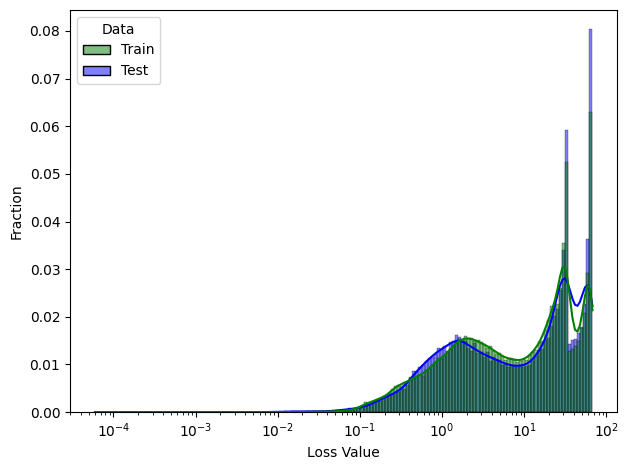

In [ ]:
plot_train_and_test_losses(train_loss_values, test_loss_values)

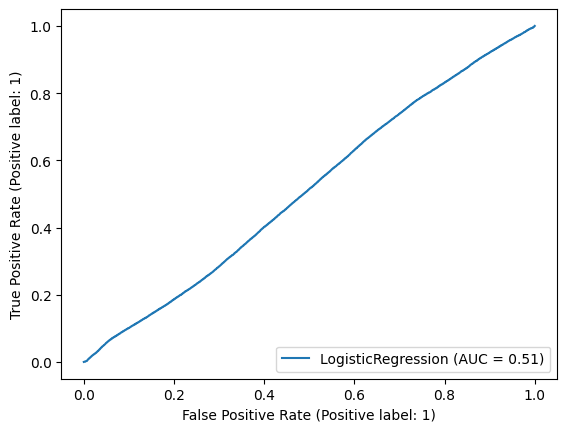

In [ ]:
get_mia_model_roc_curve(train_loss_values, test_loss_values)

## CNN

In [ ]:
# Define a HAR CNN model
class CNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(input_size, 256, 5)
        self.conv2 = nn.Conv1d(256, 128, 5)
        self.conv3 = nn.Conv1d(128, 64, 5)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(6592, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.sigm = nn.Sigmoid()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.dropout(x)
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = F.relu(self.conv3(x))
        
        x = self.flatten(x)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.sigm(x)
        return x

### Train Non-Private CNN

In [ ]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(device)

cuda


In [ ]:
# Define hyperparameters
non_private_cnn_args = {
    'epochs': 10,  # number of epochs for training model
    'lr': 0.001,  # learning rate for training model
    'disable_dp': True,  # non-private training
}

input_size = 1  # input_dim = 1 (1d feature)
num_classes = y_train.shape[1]  # 51
non_private_cnn_model = CNN(input_size, num_classes).to(device)

model_id = 'non_private_cnn'
non_private_cnn_optimizer = optim.Adam(
    non_private_cnn_model.parameters(), 
    lr=non_private_cnn_args['lr'], 
)
privacy_engine = None

In [ ]:
# Train and test model
train_losses, test_losses = [], []
train_accs, test_accs = [], []
for epoch in range(1, non_private_cnn_args['epochs'] + 1):
    train_loss = train(
        non_private_cnn_args, 
        non_private_cnn_model, 
        device, 
        train_dataloader, 
        non_private_cnn_optimizer, 
        privacy_engine, 
        epoch,
        channel_format='channels_last'
    )
    train_losses.append(train_loss)
    
    train_acc = compute_accuracy(
        non_private_cnn_model, 
        device,
        train_dataloader,
        channel_format='channels_last'
    )
    train_accs.append(train_acc)
    
    test_loss = test(non_private_cnn_model, 
                     device, 
                     test_dataloader,
                     channel_format='channels_last'
                     )
    test_losses.append(test_loss)
    
    test_acc = compute_accuracy(
        non_private_cnn_model, 
        device,
        test_dataloader,
        channel_format='channels_last'
    )
    test_accs.append(test_acc)

100%|██████████| 979/979 [00:07<00:00, 132.12it/s]


Train Epoch: 1 	 Loss: 0.693147
Computed accuracy: 0.14839870113332485


100%|██████████| 207/207 [00:00<00:00, 366.90it/s]


Test Loss: 0.693147
Computed accuracy: 0.11621258306984493


 23%|██▎       | 224/979 [00:01<00:05, 125.96it/s]


KeyboardInterrupt: ignored

In [ ]:
torch.save({
    'epoch': non_private_cnn_args['epochs'],
    'model_state_dict': non_private_cnn_model.state_dict(),
    'optimizer_state_dict': non_private_cnn_optimizer.state_dict(),
}, f"models/{model_id}")

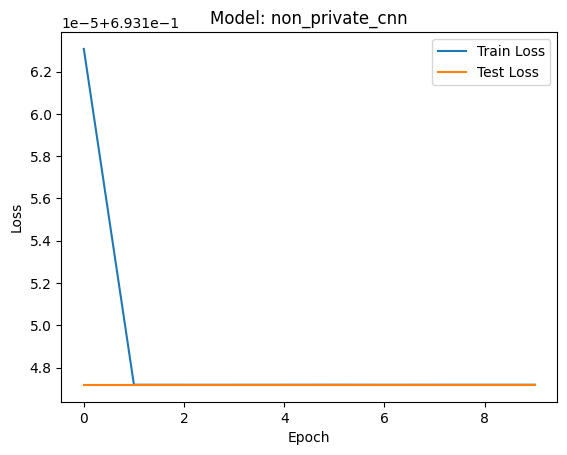

In [ ]:
plot_train_and_test_loss(model_id, train_losses, test_losses)

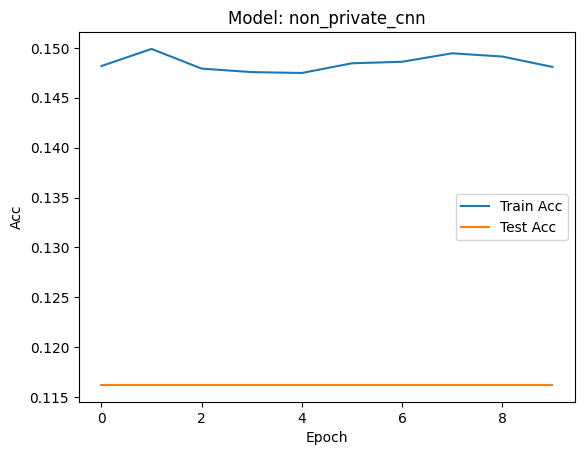

In [ ]:
plot_train_and_test_acc(model_id, train_accs, test_accs)

### Membership Inference Attack on Non-Private CNN

In [ ]:
train_loss_values = get_loss_values(non_private_cnn_model, 
                                    device, train_dataloader,
                                    channels_format='channels_last')
test_loss_values = get_loss_values(non_private_cnn_model, 
                                   device, test_dataloader,
                                   channels_format='channels_last')

100%|██████████| 207/207 [00:03<00:00, 59.28it/s]


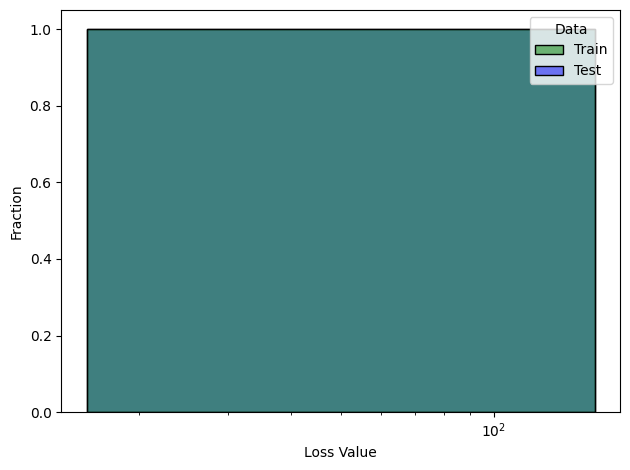

In [ ]:
plot_train_and_test_losses(train_loss_values, test_loss_values)

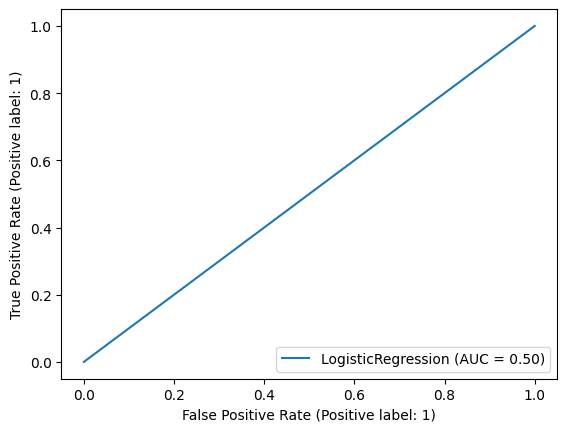

In [ ]:
get_mia_model_roc_curve(train_loss_values, test_loss_values)

### Train Private CNN

In [ ]:
# Define hyperparameters
private_cnn_args = {
    'epochs': 10,  # number of epochs for training model
    'lr': 0.001,  # learning rate for training model
    'disable_dp': False,  # non-private training,
     # flag to enable secure RNG to have trustworthy privacy guarantees (comes at a performance cost)
    'secure_rng': False,  
    'epsilon': 0.125,
    'delta': 1e-5,  # target delta for (eps, delta)-DP
    'max_per_sample_grad_norm': 1.0  # per-sample clipping norm for DP-SGD
}

input_size = 1
num_classes = y_train.shape[1]
private_cnn_model = CNN(input_size, num_classes).to(device)

model_id = 'private_simple_nn'
private_cnn_optimizer = optim.Adam(
    private_cnn_model.parameters(), 
    lr=private_cnn_args['lr'], 
)
privacy_engine = PrivacyEngine(secure_mode=private_cnn_args['secure_rng'])

private_cnn_model, private_cnn_optimizer, train_dataloader = privacy_engine.make_private_with_epsilon(
    module=private_cnn_model,
    optimizer=private_cnn_optimizer,
    data_loader=train_dataloader,
    target_epsilon=private_simple_nn_args['epsilon'],
    target_delta=private_simple_nn_args['delta'],
    epochs=private_simple_nn_args['epochs'],
    max_grad_norm=private_cnn_args['max_per_sample_grad_norm'],
)

In [ ]:
# Train and test model
train_losses, test_losses = [], []
train_accs, test_accs = [], []
for epoch in range(1, private_cnn_args['epochs'] + 1):
    train_loss = train(
        private_cnn_args, 
        private_cnn_model, 
        device, 
        train_dataloader, 
        private_cnn_optimizer, 
        privacy_engine, 
        epoch,
        channel_format='channels_last'
    )
    train_losses.append(train_loss)

    train_acc = compute_accuracy(
        private_cnn_model, 
        device,
        train_dataloader,
        channel_format='channels_last'
    )
    train_accs.append(train_acc)
    
    test_loss = test(private_cnn_model, 
                     device, 
                     test_dataloader,
                     channel_format='channels_last')
    test_losses.append(test_loss)

    test_acc = compute_accuracy(
        private_cnn_model, 
        device,
        test_dataloader,
        channel_format='channels_last'
    )
    test_accs.append(test_acc)

  0%|          | 0/979 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
100%|██████████| 979/979 [00:31<00:00, 30.64it/s]


Train Epoch: 1 	Loss: 0.693752 (ε = 0.04, δ = 1e-05)
Computed accuracy: 0.40750028905536706


100%|██████████| 207/207 [00:00<00:00, 361.79it/s]


Test Loss: 0.701422
Computed accuracy: 0.4090349698013897


  0%|          | 0/979 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
100%|██████████| 979/979 [00:31<00:00, 31.11it/s]
/usr/local/lib/python3.9/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/opacus/accountants/analysis/prv/prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)


Train Epoch: 2 	Loss: 0.757304 (ε = 0.06, δ = 1e-05)
Computed accuracy: 0.4051109579160872


100%|██████████| 207/207 [00:00<00:00, 357.30it/s]


Test Loss: 0.763567
Computed accuracy: 0.3956491281216275


  0%|          | 0/979 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
100%|██████████| 979/979 [00:31<00:00, 31.21it/s]
/usr/local/lib/python3.9/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/opacus/accountants/analysis/prv/prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)


Train Epoch: 3 	Loss: 0.779729 (ε = 0.07, δ = 1e-05)
Computed accuracy: 0.3997471062352628


100%|██████████| 207/207 [00:00<00:00, 364.11it/s]


Test Loss: 0.772598
Computed accuracy: 0.3937557983225098


  0%|          | 0/979 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
100%|██████████| 979/979 [00:31<00:00, 31.05it/s]
/usr/local/lib/python3.9/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/opacus/accountants/analysis/prv/prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)


Train Epoch: 4 	Loss: 0.823836 (ε = 0.08, δ = 1e-05)
Computed accuracy: 0.6245726547050017


100%|██████████| 207/207 [00:00<00:00, 360.65it/s]


Test Loss: 0.877735
Computed accuracy: 0.5836946437699982


  0%|          | 0/979 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
100%|██████████| 979/979 [00:31<00:00, 30.84it/s]
/usr/local/lib/python3.9/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/opacus/accountants/analysis/prv/prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)


Train Epoch: 5 	Loss: 0.871886 (ε = 0.08, δ = 1e-05)
Computed accuracy: 0.6275637828888313


100%|██████████| 207/207 [00:00<00:00, 359.72it/s]


Test Loss: 0.902305
Computed accuracy: 0.5878410360300661


  0%|          | 0/979 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
100%|██████████| 979/979 [00:31<00:00, 31.19it/s]
/usr/local/lib/python3.9/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/opacus/accountants/analysis/prv/prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)


Train Epoch: 6 	Loss: 0.908890 (ε = 0.09, δ = 1e-05)
Computed accuracy: 0.6109871100943027


100%|██████████| 207/207 [00:00<00:00, 303.24it/s]


Test Loss: 0.886042
Computed accuracy: 0.5821989132286953


  0%|          | 0/979 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
100%|██████████| 979/979 [00:31<00:00, 31.07it/s]
/usr/local/lib/python3.9/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/opacus/accountants/analysis/prv/prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)


Train Epoch: 7 	Loss: 0.959345 (ε = 0.10, δ = 1e-05)
Computed accuracy: 0.6285825743583211


100%|██████████| 207/207 [00:00<00:00, 357.12it/s]


Test Loss: 0.941695
Computed accuracy: 0.5831645114262454


  0%|          | 0/979 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
100%|██████████| 979/979 [00:31<00:00, 31.24it/s]
/usr/local/lib/python3.9/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/opacus/accountants/analysis/prv/prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)


Train Epoch: 8 	Loss: 0.994057 (ε = 0.11, δ = 1e-05)
Computed accuracy: 0.6292602691599829


100%|██████████| 207/207 [00:00<00:00, 358.19it/s]


Test Loss: 0.949354
Computed accuracy: 0.5819338470568188


  0%|          | 0/979 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
100%|██████████| 979/979 [00:31<00:00, 31.31it/s]
/usr/local/lib/python3.9/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/opacus/accountants/analysis/prv/prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)


Train Epoch: 9 	Loss: 1.049808 (ε = 0.11, δ = 1e-05)
Computed accuracy: 0.6257238160899385


100%|██████████| 207/207 [00:00<00:00, 360.10it/s]


Test Loss: 1.001575
Computed accuracy: 0.5812333150311453


  0%|          | 0/979 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
100%|██████████| 979/979 [00:31<00:00, 30.98it/s]
/usr/local/lib/python3.9/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/opacus/accountants/analysis/prv/prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)


Train Epoch: 10 	Loss: 1.149641 (ε = 0.12, δ = 1e-05)
Computed accuracy: 0.5949330250358794


100%|██████████| 207/207 [00:00<00:00, 351.99it/s]


Test Loss: 1.257234
Computed accuracy: 0.5473427116269383


In [ ]:
torch.save({
    'epoch': private_cnn_args['epochs'],
    'model_state_dict': private_cnn_model.state_dict(),
    'optimizer_state_dict': private_cnn_optimizer.state_dict(),
}, f"models/{model_id}")

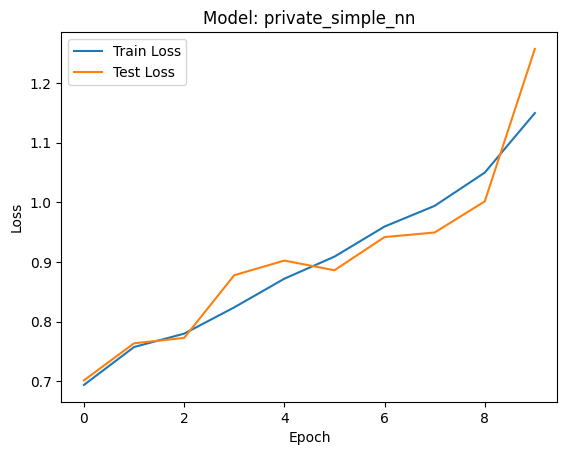

In [ ]:
plot_train_and_test_loss(model_id, train_losses, test_losses)

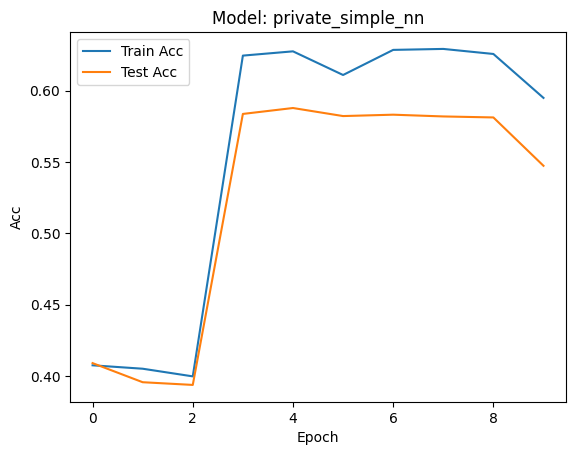

In [ ]:
plot_train_and_test_acc(model_id, train_accs, test_accs)

### Membership Inference Attack on Private CNN

In [ ]:
train_loss_values = get_loss_values(private_cnn_model, 
                                    device, train_dataloader,
                                    channels_format='channels_last')
test_loss_values = get_loss_values(private_cnn_model, 
                                   device, test_dataloader,
                                   channels_format='channels_last')

100%|██████████| 207/207 [00:03<00:00, 57.93it/s]


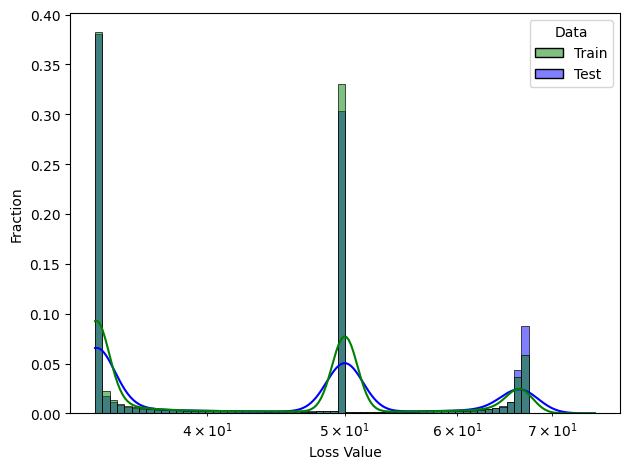

In [ ]:
plot_train_and_test_losses(train_loss_values, test_loss_values)

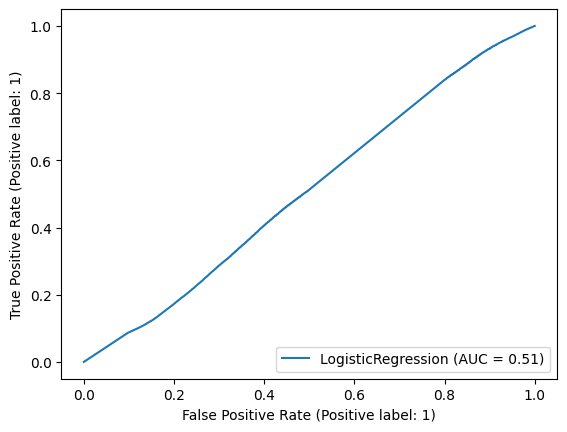

In [ ]:
get_mia_model_roc_curve(train_loss_values, test_loss_values)

## LSTM